# Práctica de PySpark Machine Learning

## 1. Objetivo

Dado el siguente dataset:

https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv

Cuyas variables representan:

- **age**: edad del beneficiario principal
- **sex**: género del contratante del seguro, femenino, masculino
- **bmi**: índice de masa corporal, que proporciona una comprensión del cuerpo, de los pesos que son relativamente altos o bajos en relación con la altura, índice objetivo de peso corporal (kg / m ^ 2) utilizando la relación entre la altura y el peso, idealmente entre 18,5 y 24,9.
- **children**: número de hijos cubiertos por el seguro de salud / número de dependientes
- **smoker**: si fuma o no
- **region**: área de residencia del beneficiario en EE. UU., noreste, sureste, suroeste, noroeste.
- **charges**: costos médicos individuales facturados por el seguro de salud.


1. Utilizando la API de pandas de PySpark, realiza un EDA del dataset anterior.
2. Luego conviertelós a un DataFrame de Spark normal, realiza las conversiones necesarias para poder hacer machine learning (StringIndexer, StandardScaler, VectorAssembler...) y aplica un modelo de regresión lineal usando pyspark.ml

La variable objetivo a predecir sería **charges**.

## 2. Analytics

### 2.1. Load Libraries

In [1]:
# Install pyspark
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [28]:
# Import libraries for EDA
%matplotlib inline
import pyspark.pandas as ps
import pandas as pd
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import OneHotEncoder

### 2.2. Load the data

In [29]:
# Initialize Spark session
spark = SparkSession.builder.appName("InsuranceLogisticRegression").getOrCreate()

#Import the data
df = ps.read_csv("insurance.csv", sep=",")
df.head(10)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 2.3. Data Quality

Data Quality Analysis phase, ensuring the integrity and usability of data is crucial. Here are the steps that I will follow to check the data quality:

1. Check for Missing Values (Null Data)
* Identify Missing Values: Use functions like isnull() or isna() in pandas to identify missing values.
* Quantify Missing Values: Determine the percentage of missing values in each column to understand the extent of the issue.
* Handle Missing Values: Decide on a strategy to handle missing values, such as: remove or impute missing data.

2. Check for Duplicate Data

* Identify Duplicates: Use functions like duplicated() to find duplicate rows.
* Remove Duplicates: Remove duplicates using drop_duplicates().

3. Check for Inconsistent Data

* Consistency Checks: Ensure that categorical data values are consistent. For example, check for variations in the category names("USA" vs "U.S.A" vs "United States")
* Standardization: Standardize categorical variables to a consistent format.

4. Check for Outliers
* Identify Outliers: Use visualizations (box plots, scatter plots) and statistical methods (Z-score, IQR) to detect outliers.
* Handle Outliers: Decide whether to remove, transform, or keep outliers based on their impact on the analysis.

#### 2.3.1. Check for Null Data

In [4]:
print(df.isna().sum().sort_values(ascending=False))

df.info()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int32  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int32  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int32(2), object(3)

Conclusions:
* There are not any null data.

#### 2.3.2. Check for Duplicate Data

In [5]:
ps.options.compute.ops_on_diff_frames = True

# Create an additional column indicating duplicate rows
df["is_duplicated"] = df.duplicated(keep=False)

# Filters the DataFrame to show only duplicate rows
duplicated_rows = df[df["is_duplicated"]]

# Delete the auxiliary column "is_duplicated"
duplicated_rows = duplicated_rows.drop(columns=["is_duplicated"])
df = df.drop(columns=["is_duplicated"])

# Muestra las filas duplicadas
duplicated_rows

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


Conclusions:
* There are is only one duplicated row → delete the second one

In [6]:
# Drop the row 581
df = df.drop(index=581)

#### 2.3.3. Check for Inconsistent data

In [7]:
categorical_data = df.select_dtypes("O")
numerical_data = df.select_dtypes(["int32", "float64"])

for col in categorical_data.columns:
    print(col)
    print(categorical_data[col].unique())
    print("*********************************************************")

sex
0    female
1      male
Name: sex, dtype: object
*********************************************************
smoker
0     no
1    yes
Name: smoker, dtype: object
*********************************************************
region
0    northwest
1    southeast
2    northeast
3    southwest
Name: region, dtype: object
*********************************************************


Conclusions:
* It seems the categorical data is correct and there are not any inconsistency.

#### 2.3.4. Check for outliers

In [8]:
def outlier_detection(data, features):
    """
    Takes a dataframe and a list of the columns that is decided to apply Tukey's method for detecting outliers.
    Returns a list of indices that are considered outliers.
    """
    outlier_indices = []
    n = 2  # threshold

    # Convert the data to a pandas DataFrame
    data_pd = data.to_pandas()

    # Iterate over each feature
    for col in features:
        # Calculate quartiles
        Q1 = np.percentile(data_pd[col], 25)
        Q3 = np.percentile(data_pd[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Determine the index of the outliers for feature col
        outlier_list_col = data_pd[(data_pd[col] < Q1 - 1.5 * IQR) | (data_pd[col] > Q3 + 1.5 * IQR)].index

        # Append indices of outliers for every col
        outlier_indices.extend(outlier_list_col)

    # Count occurrences of each index
    outlier_count = Counter(outlier_indices)

    # Select indices with more than n outliers
    multiple_outliers = [index for index, count in outlier_count.items() if count > n]

    return multiple_outliers

In [9]:
outliers_to_drop = outlier_detection(numerical_data, numerical_data.columns)
print(outliers_to_drop)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


[]


Conclusions:
- There are not any outliers due to Tukey´s outliers detection method.

### 2.4. EDA Categorical Data

In [10]:
categorical_data.columns

Index(['sex', 'smoker', 'region'], dtype='object')

In [11]:
def charts_eda_categorical(cat):
  for col in cat.columns:
      plt.figure(figsize=(8, 5))
      value_counts = cat[col].value_counts()
      plt.barh(value_counts.index.tolist(), value_counts.values.tolist())  # Convert to list
      plt.title(col, fontsize=12, fontweight="bold")
      plt.xlabel('Count', fontsize=10)
      plt.ylabel(col, fontsize=10)
      plt.show()
      plt.close()
      print(value_counts)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


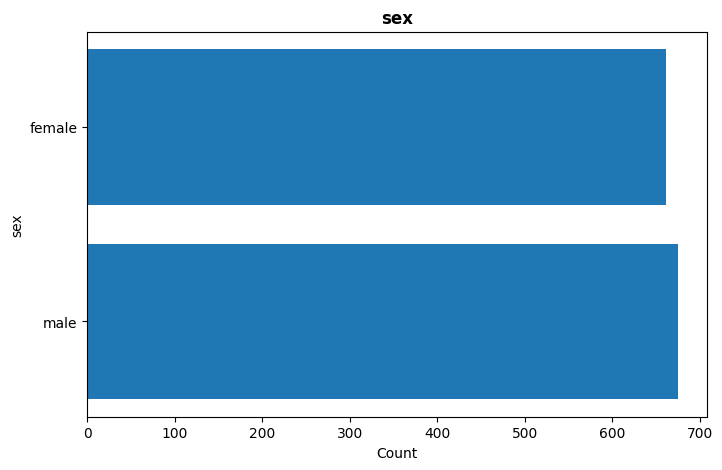

male      675
female    662
Name: sex, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


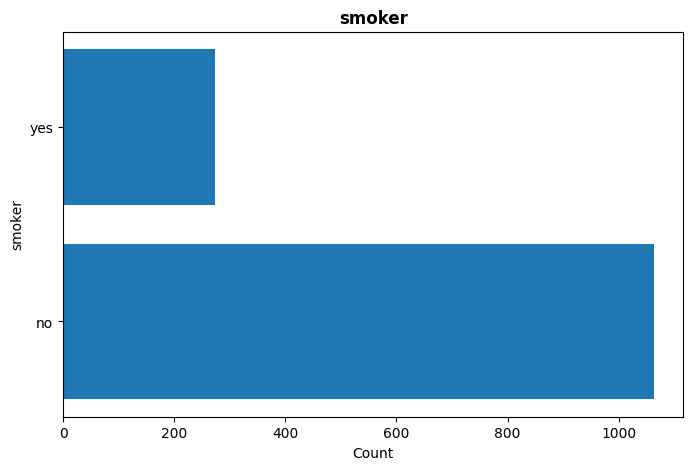

no     1063
yes     274
Name: smoker, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


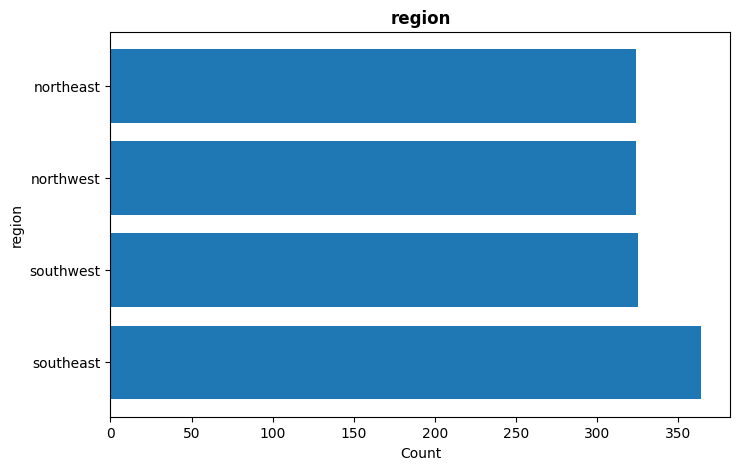

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64


In [12]:
charts_eda_categorical(categorical_data)

Conclusions:
- **sex** column → The female/male ratio of insurance contractors is approximately 50/50.
- **smoker** column → The vast majority of insurance policyholders are non-smokers, approximately 80%.
- **region** column → Seem very close in numbers, especially between southwest, northwest, and northeast. In a real-world dataset, such close numbers can occur, but they might raise a suspicion of artificial manipulation or a perfectly balanced sampling process.

### 2.5. EDA Numerical Data

In [13]:
def statistics_cont(num):
    #use describe method transposed
    statistics = num.describe().T
    #Add the median
    statistics['median'] = num.median()
    # rearrange so that the median is next to the mean.
    statistics = statistics.iloc[:, [0, 1, 8, 2, 3, 4, 5, 6, 7]]
    return(statistics)

In [14]:
statistics_cont(numerical_data)

,count,mean,median,std,min,25%,50%,75%,max
age,1337.0,39.222139,39.0000,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,30.4000,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
charges,1337.0,13279.121487,9386.1613,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801
children,1337.0,1.095737,1.0000,1.205571,0.0000,0.000,1.0000,2.00000,5.00000


Conclusions:
- The insurance policyholders have an age range between [18, 64] with an average of approximately 39 years. This seems quite reasonable.

- The average Body Mass Index in this dataset is approximately 30. However a normal BMI due to WHO is 18.5 to 24.9.

- The average insurance policyholder has one child. However the range is [0, 5].


### 2.6. Insights generation

##### 2.6.1. What are the company's annual charges? What are the overall average charges for the company?

In [15]:
print("Total charges:", df.charges.sum())
print("Average charges:", df.charges.mean())

Total charges: 17754185.427659
Average charges: 13279.121486655948


#### 2.6.2. Do men or women pay more for insurance?



In [16]:
temp = df.groupby("sex")["charges"].mean().sort_values(ascending=False)
temp.plot.bar()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:649: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(


#### 2.6.3. Do smokers pay more for insurance compared to non-smokers?

In [17]:
temp = df.groupby("smoker")["charges"].mean().sort_values(ascending=False)
temp.plot.bar()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:649: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.



#### 2.6.4. How does BMI relate to the insurance charge?

In [18]:
# Define function to categorize BMI
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal bodyweight'
    elif 25 <= bmi < 30:
        return 'overweight'
    elif 30 <= bmi < 35:
        return 'obese'
    else:
        return 'extreme obese'

In [19]:
df["cat_bmi"] = df["bmi"].apply(categorize_bmi)

temp = df.groupby("cat_bmi")["charges"].mean().sort_values(ascending=False)
temp.plot.bar()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:649: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.



#### 2.6.5. Do the BMI affects the charge the same way in smokers and non smokers?

In [20]:
# Filter the DataFrame for smokers and non-smokers
smokers = df[df['smoker'] == 'yes']
non_smokers = df[df['smoker'] == 'no']

# Group by bmi_categorical and compute the mean charges for smokers and non-smokers
smokers_mean_charges = smokers.groupby('cat_bmi')['charges'].mean().sort_values(ascending=False)
non_smokers_mean_charges = non_smokers.groupby('cat_bmi')['charges'].mean().sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:649: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.



/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.



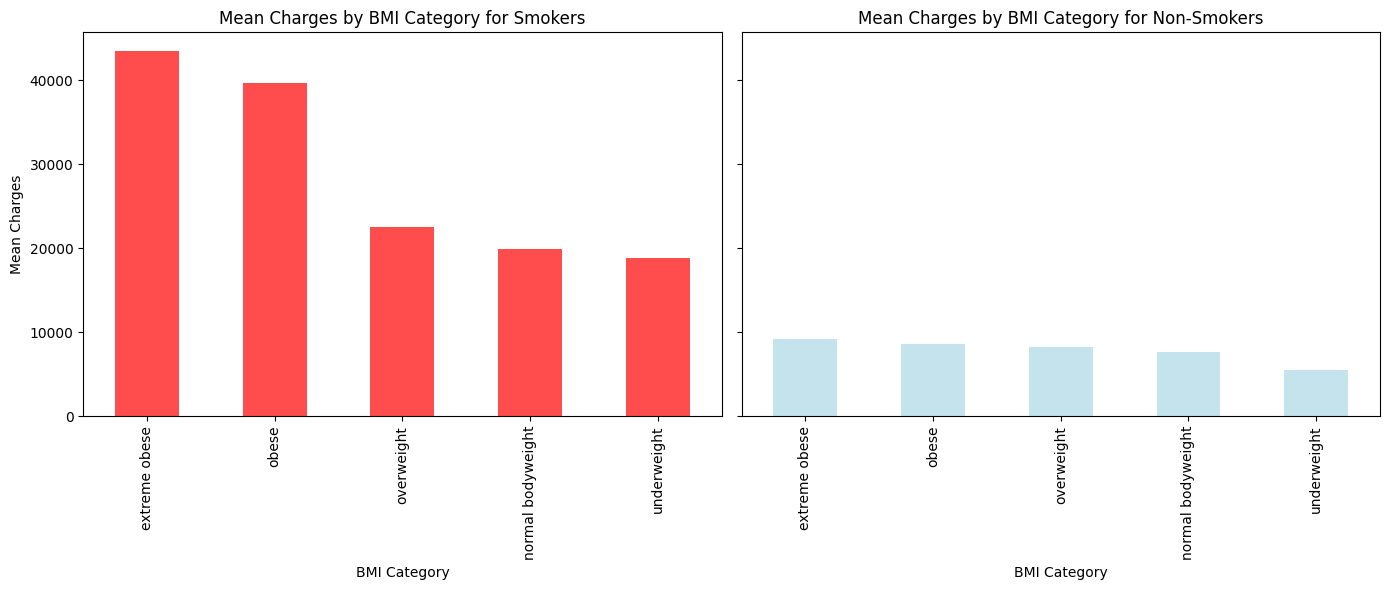

In [21]:
# Convert to Pandas DataFrame
smokers_mean_charges_pd = smokers_mean_charges.to_pandas()
non_smokers_mean_charges_pd = non_smokers_mean_charges.to_pandas()

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for smokers
smokers_mean_charges_pd.plot(kind='bar', ax=axes[0], color='red', alpha=0.7, title='Mean Charges by BMI Category for Smokers')
axes[0].set_xlabel('BMI Category')
axes[0].set_ylabel('Mean Charges')

# Plot for non-smokers
non_smokers_mean_charges_pd.plot(kind='bar', ax=axes[1], color='lightblue', alpha=0.7, title='Mean Charges by BMI Category for Non-Smokers')
axes[1].set_xlabel('BMI Category')

plt.tight_layout()
plt.show()

## 3. Machine Learning

### 3.1. Data Engineering

I have decided to remove the original "bmi" column and use the groupings I made in the "cat_bmi" column for my Machine Learning model.

In [22]:
df_ml = df.copy()

df_ml = df_ml.drop(columns=["bmi"])

### 3.2. Preprocessing

The algorithm that I will use for ML is Linear Regression. This algorith can handle binary categorical variables. For this reason I will not do OneHotEncoding for the binary columns. My approach will be the next:
- **sex** → Categorical to Numerical Data (0→female, 1→male)
- **smoker** → Categorical to Numerical Data (0→no, 1→yes)
- **region** → OneHotEncoding→expand unique values as columns
- **cat_bmi** → OneHotEncoding→expand unique values as columns

In [23]:
# Transform Categorical "sex" to Numerical
df_ml["sex"] = df_ml["sex"].map({"female": 0, "male": 1})

# Transform Categorical "smoker" to Numerical
df_ml["smoker"] = df_ml["smoker"].map({"no": 0, "yes": 1})

In [24]:
# OheHotEncoding → Transform Nominal Data to Numeric Data, expand unique values as columns
df_ml = df_ml.to_pandas()

ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

ohe_transform = ohe.fit_transform(df_ml[["region", "cat_bmi"]])

df_ml = pd.concat([df_ml, ohe_transform], axis=1).drop(columns=["region", "cat_bmi"])

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



In [25]:
df_ml.head()

,age,sex,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,cat_bmi_extreme obese,cat_bmi_normal bodyweight,cat_bmi_obese,cat_bmi_overweight,cat_bmi_underweight
0,19,0,0,1,16884.92400,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,18,1,1,0,1725.55230,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28,1,3,0,4449.46200,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,33,1,0,0,21984.47061,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,32,1,0,0,3866.85520,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 3.3. Modeling

In [30]:
# Convert pandas DataFrame to PySpark DataFrame
spark_df = spark.createDataFrame(df_ml)
spark_df.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- children: long (nullable = true)
 |-- smoker: string (nullable = true)
 |-- charges: double (nullable = true)
 |-- region_northeast: double (nullable = true)
 |-- region_northwest: double (nullable = true)
 |-- region_southeast: double (nullable = true)
 |-- region_southwest: double (nullable = true)
 |-- cat_bmi_extreme obese: double (nullable = true)
 |-- cat_bmi_normal bodyweight: double (nullable = true)
 |-- cat_bmi_obese: double (nullable = true)
 |-- cat_bmi_overweight: double (nullable = true)
 |-- cat_bmi_underweight: double (nullable = true)

